In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
train_dir="/kaggle/input/car-object-detection/data/training_images"
test_dir="/kaggle/input/car-object-detection/data/testing_images"

train_labels="/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv"

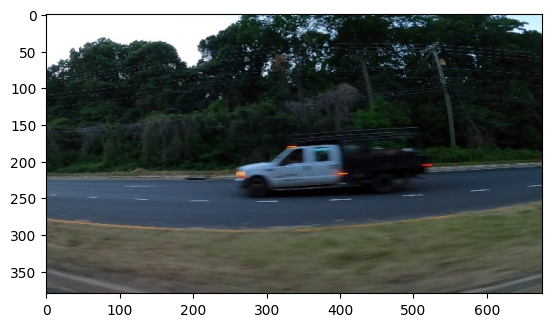

In [4]:
import matplotlib.pyplot as plt

img_name = os.listdir(test_dir)[100]
img_path = os.path.join(test_dir, img_name)

img = plt.imread(img_path)
plt.imshow(img) 
plt.show()


In [5]:
from PIL import Image
img_path = os.path.join(test_dir, os.listdir(test_dir)[30])
img = Image.open(img_path)
img.size

(676, 380)

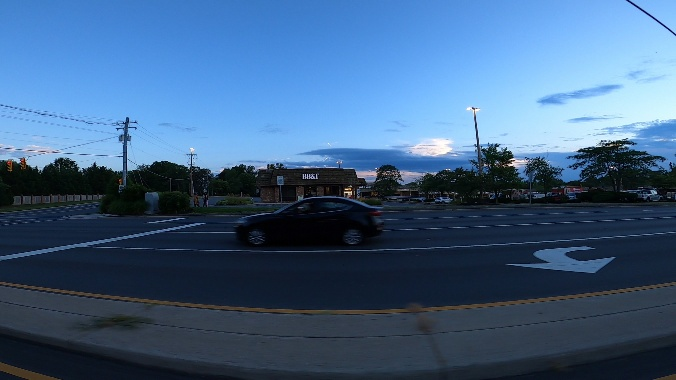

In [6]:
img_path = os.path.join(train_dir, os.listdir(train_dir)[700])
img = Image.open(img_path)
img

In [7]:
#DETR preprocessing
from transformers import DetrFeatureExtractor;
feature_extractor = DetrFeatureExtractor.from_pretrained('facebook/detr-resnet-50') 

2024-05-10 06:56:39.067154: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 06:56:39.067216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 06:56:39.068099: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


In [8]:
#DETR model
from transformers import DetrForObjectDetection
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
inputs = feature_extractor(images=img, return_tensors="pt") 

In [10]:
inputs.keys()

dict_keys(['pixel_values', 'pixel_mask'])

In [11]:
inputs['pixel_values'].shape

torch.Size([1, 3, 749, 1332])

In [12]:
inputs['pixel_mask'].shape

torch.Size([1, 749, 1332])

In [20]:
outputs = model(**inputs)

In [21]:
outputs.keys()

odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])

In [22]:
outputs['pred_boxes'].shape

torch.Size([1, 100, 4])

In [23]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{model.config.id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [25]:
import torch

# keep only predictions of queries with 0.9+ confidence (excluding no-object class)
probas = outputs.logits.softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# rescale bounding boxes
target_sizes = torch.tensor(img.size[::-1]).unsqueeze(0)
postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
bboxes_scaled = postprocessed_outputs[0]['boxes'][keep]

`post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection` instead, with `threshold=0.` for equivalent results.


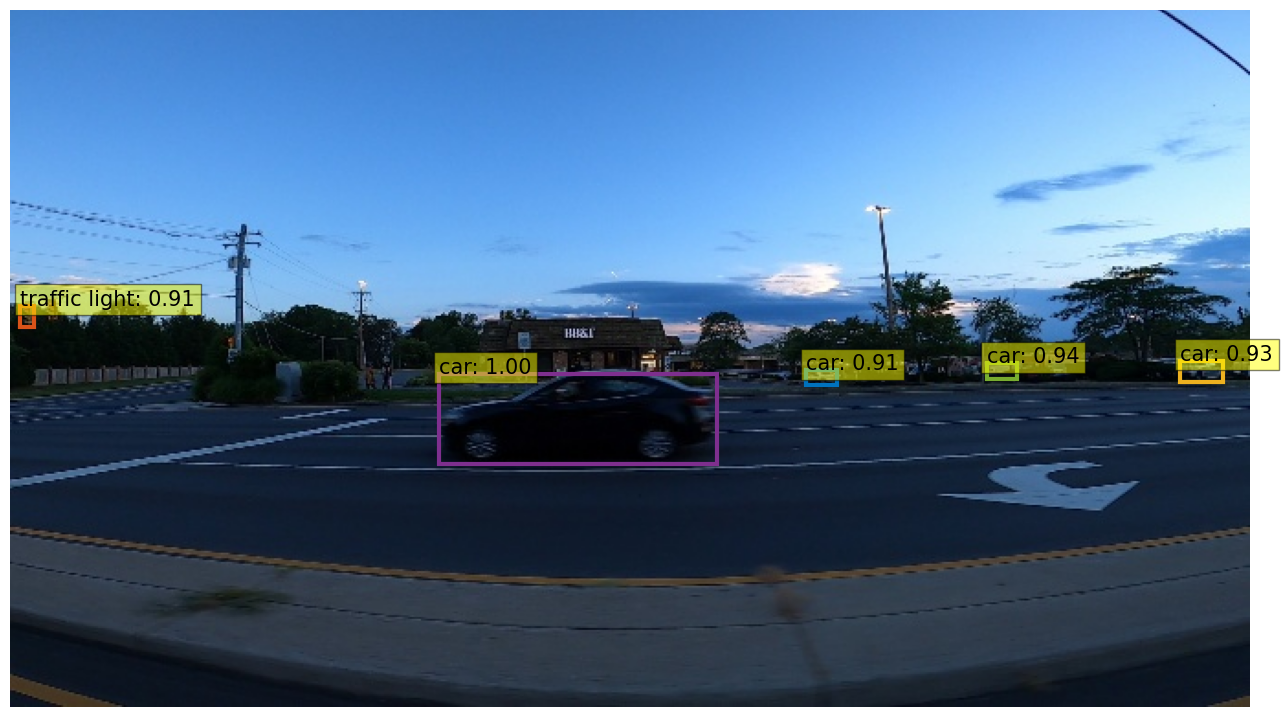

In [26]:
plot_results(img, probas[keep], bboxes_scaled)